# Objective
1. What changes company should bring to reduce the number of absenteeism?
2. How much losses every month can we project in 2011 if same trend of
absenteeism continues?

In [2]:
#Operation on dataframe and numbers
import pandas as pd
import numpy as np

#to check the plot inline
%matplotlib inline
import matplotlib.pyplot as plt

#For plotting
import seaborn as sns
import matplotlib.gridspec as gridspec 


#For imputing missing values
from fancyimpute import KNN  

#sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import tree



#For Time series Analyis
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

#Chi-square test
from scipy.stats import chi2_contingency

In [3]:
#Importing dataset
#dateparse = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
complete_data = pd.read_excel("Absenteeism_at_work_Project.xls")

In [4]:
complete_data.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0
2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0
3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,...,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0


In [5]:
complete_data.columns
#Replacing the spaces between the variable names with underscore, as it's a good practise and help with model building where
#variable with spaces are taken as string and don't work
complete_data.columns = complete_data.columns.str.replace(' ', '_')

In [6]:
#data type of the variables
complete_data.dtypes

ID                                   int64
Reason_for_absence                 float64
Month_of_absence                   float64
Day_of_the_week                      int64
Seasons                              int64
Transportation_expense             float64
Distance_from_Residence_to_Work    float64
Service_time                       float64
Age                                float64
Work_load_Average/day_             float64
Hit_target                         float64
Disciplinary_failure               float64
Education                          float64
Son                                float64
Social_drinker                     float64
Social_smoker                      float64
Pet                                float64
Weight                             float64
Height                             float64
Body_mass_index                    float64
Absenteeism_time_in_hours          float64
dtype: object

In [7]:
#no of rows and columns
print("Row : Columns")
print(complete_data.shape[0],complete_data.shape[1])
print(complete_data.columns)

Row : Columns
740 21
Index(['ID', 'Reason_for_absence', 'Month_of_absence', 'Day_of_the_week',
       'Seasons', 'Transportation_expense', 'Distance_from_Residence_to_Work',
       'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target',
       'Disciplinary_failure', 'Education', 'Son', 'Social_drinker',
       'Social_smoker', 'Pet', 'Weight', 'Height', 'Body_mass_index',
       'Absenteeism_time_in_hours'],
      dtype='object')


In [8]:
#Missing data
#Creating a dataframe of missing values
Missing_value = pd.DataFrame(complete_data.isnull().sum())
Missing_value = Missing_value.reset_index()
Missing_value = Missing_value.rename(columns = { 'index' : 'Features', 0 : 'Count'})
Missing_value

,Features,Count
0,ID,0
1,Reason_for_absence,3
2,Month_of_absence,1
3,Day_of_the_week,0
4,Seasons,0
5,Transportation_expense,7
6,Distance_from_Residence_to_Work,3
7,Service_time,3
8,Age,3
9,Work_load_Average/day_,10


In [9]:
#Exploring some important variables
complete_data.ID.nunique()

36

In [10]:
#No of person without any absent hours
complete_data_noabsentece = complete_data['Absenteeism_time_in_hours'].loc[(complete_data['Absenteeism_time_in_hours'] == 0)]
print("No of rows without any absent hours = %d" %(complete_data_noabsentece.count()))

#max and min absent hours
print('Maximum absenteeism time: %d  Min absenteeism time:  %d'%(complete_data['Absenteeism_time_in_hours'].max(), 
                                                                    complete_data['Absenteeism_time_in_hours'].min()))

No of rows without any absent hours = 36
Maximum absenteeism time: 120  Min absenteeism time:  0


In [11]:
#The categorical varibales are not in the correct type in the raw data, lets convert those variables into categorical type
#Variables to be converted
'''
1. Reason for absence
2. Month of absence
3. Day of the week
4. Seasons
5. Disciplinary failure
6. Education
7. Son
8. Social drinker
9. Social smoker
10. Pet
11. ID: Adding adding as there are mulitple observation for a single id, categorizing them as well.
'''
category_variables = ['Reason_for_absence', 'Month_of_absence', 'Day_of_the_week', 'Seasons', 'Disciplinary_failure',
                      'Education', 'Son', 'Social_drinker', 'Social_smoker', 'Pet', 'ID']
#Lets convert these variables into category type now using apply
complete_data[category_variables] = complete_data[category_variables].apply(pd.Series.astype, dtype = 'category')
#complete_data.dtypes

## Data Exploration and Preparation

In [12]:
#As we know that the data is from July 2007 to July 2010 and we don't have a "year" variable in the dataset, adding year variable
complete_data.loc[0:112, 'Year'] = 2007
complete_data.loc[113:358, 'Year'] = 2008
complete_data.loc[359:570, 'Year'] = 2009
complete_data.loc[571:740, 'Year'] = 2010

#Setting the year variable position adjacent to month i.e postion number 3
cols_name = complete_data.columns.tolist()
column_to_move = "Year"
new_position = 3
cols_name.insert(new_position, cols_name.pop(cols_name.index(column_to_move)))
complete_data = complete_data[cols_name]

In [13]:
#As we know that the we have data till July 2010, there are last three rows which have 0 month, with '0' reason of absense and 
#'0' absentese hours, removing these rows as it will create probelm while creating time series as it will take it as new month
#which in real is not
complete_data = complete_data.loc[0:736,]
complete_data.tail()

"""We have a month of 1 in 2007 which is not possible as the data is given from July 2007, seems to be a typo error as
it is between month 10, missplaced as 1. We will replace it to 10. This will also create problem as while grouping it will take
it as new month.
"""
#complete_data.loc[66, 'Month.of.absence'] = 10

'We have a month of 1 in 2007 which is not possible as the data is given from July 2007, seems to be a typo error as\nit is between month 10, missplaced as 1. We will replace it to 10. This will also create problem as while grouping it will take\nit as new month.\n'

In [15]:
#Sum of total absenteeism time
total_absent_hrs = complete_data['Absenteeism_time_in_hours'].sum()
print("Total Absenteeism hours in 3 years:   %d" %(total_absent_hrs))

#Average service time of employees
average_service_time = complete_data['Service_time'].mean()
print("Average Service Time of Employees:  %d" %(average_service_time))

#Total man days lost
total_man_days = total_absent_hrs/average_service_time
print("Total Man Days Lost in 3 years:    %d" %(total_man_days))

Total Absenteeism hours in 3 years:   5010
Average Service Time of Employees:  12
Total Man Days Lost in 3 years:    398


## Completeness of Data : Missing Imputation

In [16]:
#Imputing Misssing Values
#Create dataframe with missing percentage
missing_val = pd.DataFrame(complete_data.isnull().sum())

#Reset index
missing_val = missing_val.reset_index()

#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(complete_data))*100

#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val
#save output results 
#missing_val.to_csv("Miising_perc.csv")

,Variables,Missing_percentage
0,Body_mass_index,4.206242
1,Absenteeism_time_in_hours,2.985075
2,Height,1.899593
3,Work_load_Average/day_,1.356852
4,Education,1.356852
5,Transportation_expense,0.949796
6,Son,0.814111
7,Disciplinary_failure,0.814111
8,Hit_target,0.814111
9,Social_smoker,0.542741


In [17]:
#Apply KNN imputation algorithm
complete_data = pd.DataFrame(KNN(k = 3).complete(complete_data), columns = complete_data.columns)

Imputing row 1/737 with 0 missing, elapsed time: 0.177
Imputing row 101/737 with 1 missing, elapsed time: 0.217
Imputing row 201/737 with 0 missing, elapsed time: 0.219
Imputing row 301/737 with 0 missing, elapsed time: 0.220
Imputing row 401/737 with 0 missing, elapsed time: 0.220
Imputing row 501/737 with 0 missing, elapsed time: 0.221
Imputing row 601/737 with 0 missing, elapsed time: 0.222
Imputing row 701/737 with 0 missing, elapsed time: 0.222


In [18]:
complete_data.isnull().sum()

ID                                 0
Reason_for_absence                 0
Month_of_absence                   0
Year                               0
Day_of_the_week                    0
Seasons                            0
Transportation_expense             0
Distance_from_Residence_to_Work    0
Service_time                       0
Age                                0
Work_load_Average/day_             0
Hit_target                         0
Disciplinary_failure               0
Education                          0
Son                                0
Social_drinker                     0
Social_smoker                      0
Pet                                0
Weight                             0
Height                             0
Body_mass_index                    0
Absenteeism_time_in_hours          0
dtype: int64

In [19]:
#Converting all the variables into integer as factor variables are affected after Knn inputation
cols_name = complete_data.columns.tolist()
complete_data[cols_name] = complete_data[cols_name].apply(lambda x: round(x))

In [20]:
complete_data.describe()

,ID,Reason_for_absence,Month_of_absence,Year,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
count,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,...,737.000000,737.00000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000
mean,18.027137,19.290366,6.350068,2008.584803,3.913161,2.546811,221.527815,29.652646,12.549525,36.417910,...,0.052917,1.29308,1.017639,0.567164,0.073270,0.734057,78.983718,172.127544,26.660787,7.023066
std,11.007622,8.358790,3.419430,1.000645,1.422090,1.112329,66.900576,14.856884,4.393121,6.460297,...,0.224020,0.67435,1.100130,0.495805,0.260756,1.292682,12.866993,6.043998,4.264871,13.340982
min,1.000000,0.000000,1.000000,2007.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,10.000000,13.000000,3.000000,2008.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,...,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,2009.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,...,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,2009.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,...,0.000000,1.00000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,2010.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,...,1.000000,4.00000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


**There seems to be many outlier in the target variable after seeing the above statistics, we will eliminate the outliers first before visualizing**

## Outlier Analysis

In [21]:
#Outlier Analysis for numerical variables
#plt.figure(figsize=(20,25))
numeric_var = ['Transportation_expense', 'Distance_from_Residence_to_Work',
       'Service_time', 'Age', 'Work_load_Average/day_', 'Hit_target','Weight', 'Height', 'Body_mass_index',
        'Absenteeism_time_in_hours']
#plt.figure(figsize=(16,22))
#plt.suptitle("Univariate boxplot",fontsize=20)
#gridspec.GridSpec(4,2)
#plt.subplot2grid((4,2),(0,0))
z = 2
for i in numeric_var:
   #gridspec.GridSpec(len(columns),1)
    #plt.subplot2grid((len(columns),2),(0,0))
    plt.title(i,fontsize=15)
    sns.boxplot(
    y = complete_data[i],
    data=complete_data)
    #plt.show()
    plt.savefig("value{z}.png".format(z=z))
    plt.close()
    z = z + 1

In [22]:
complete_data[numeric_var] = complete_data[numeric_var].apply(pd.Series.astype, dtype = 'int')

In [23]:
for i in numeric_var:
    q75, q25 = np.percentile(complete_data.loc[:,i], [75, 25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(min), print(max)
    complete_data.loc[complete_data[i] < minimum,i] = np.nan
    complete_data.loc[complete_data[i] > maximum, i] = np.nan

<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>
<built-in function min>
<built-in function max>


In [24]:
complete_data.isnull().sum()

ID                                   0
Reason_for_absence                   0
Month_of_absence                     0
Year                                 0
Day_of_the_week                      0
Seasons                              0
Transportation_expense               3
Distance_from_Residence_to_Work      0
Service_time                         5
Age                                  8
Work_load_Average/day_              31
Hit_target                          19
Disciplinary_failure                 0
Education                            0
Son                                  0
Social_drinker                       0
Social_smoker                        0
Pet                                  0
Weight                               0
Height                             119
Body_mass_index                      0
Absenteeism_time_in_hours           46
dtype: int64

In [25]:
#Imputing Outlier using KNN
complete_data = pd.DataFrame(KNN(k = 3).complete(complete_data), columns = complete_data.columns)

Imputing row 1/737 with 0 missing, elapsed time: 0.144
Imputing row 101/737 with 1 missing, elapsed time: 0.145
Imputing row 201/737 with 0 missing, elapsed time: 0.146
Imputing row 301/737 with 0 missing, elapsed time: 0.148
Imputing row 401/737 with 0 missing, elapsed time: 0.148
Imputing row 501/737 with 0 missing, elapsed time: 0.149
Imputing row 601/737 with 0 missing, elapsed time: 0.152
Imputing row 701/737 with 0 missing, elapsed time: 0.153


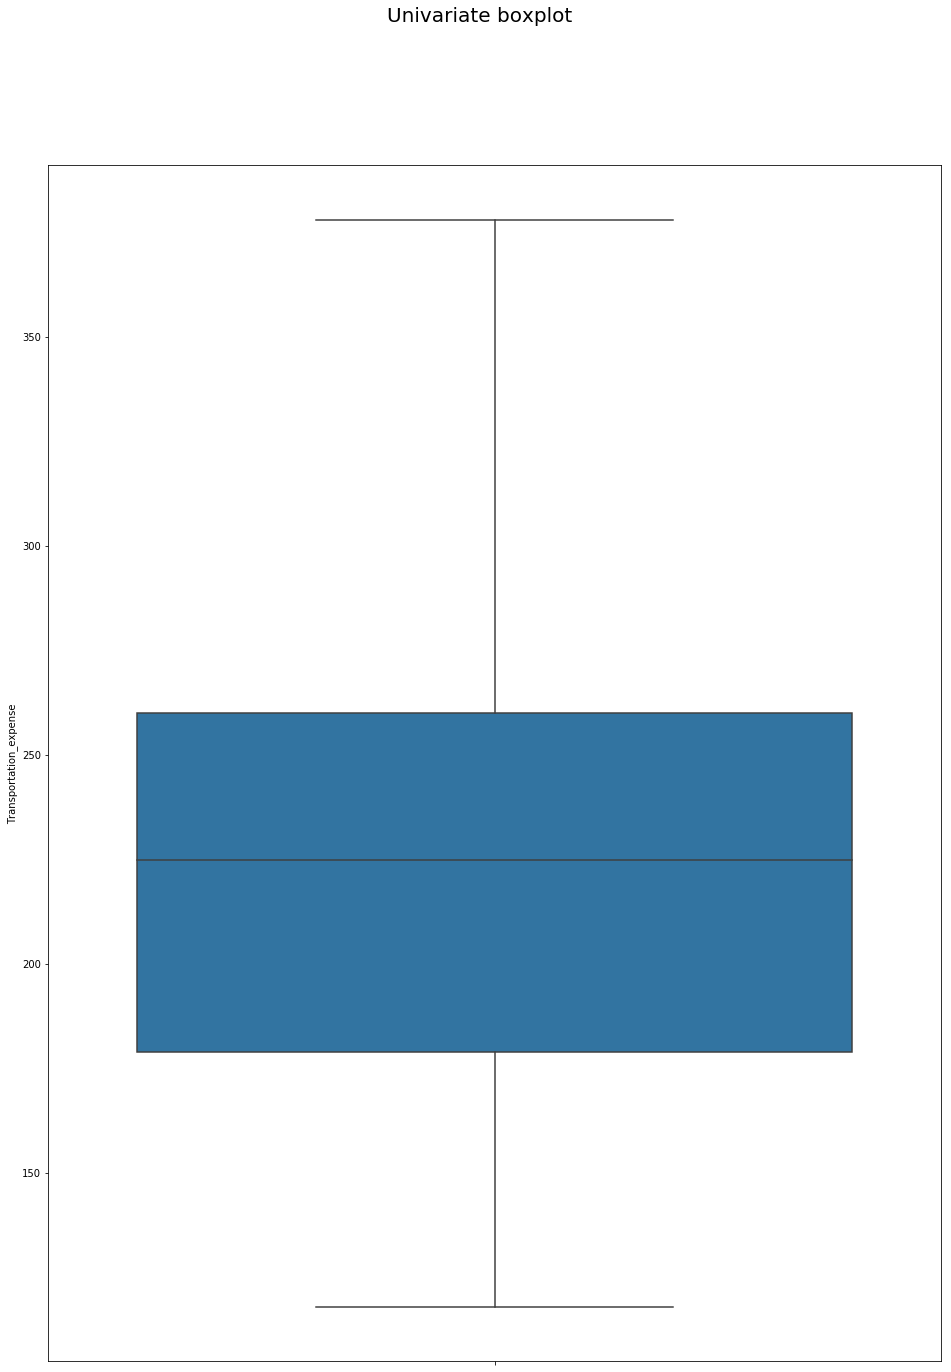

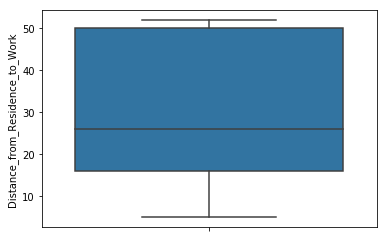

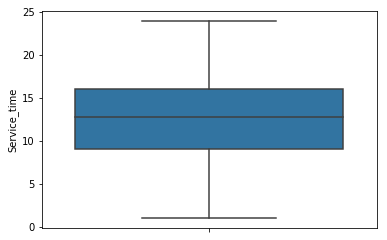

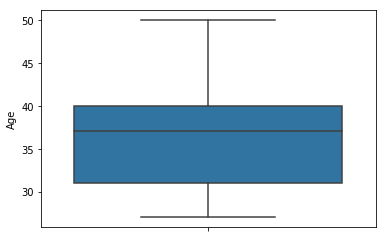

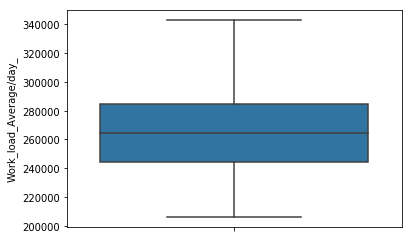

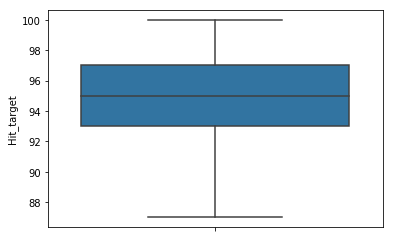

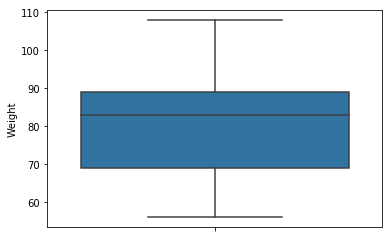

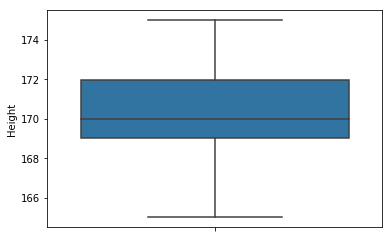

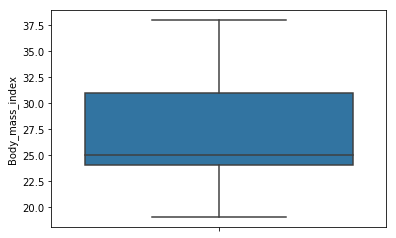

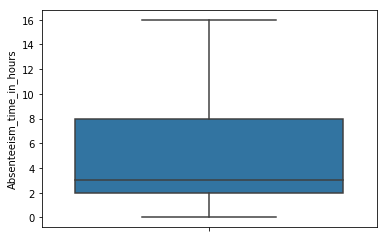

In [26]:
plt.figure(figsize=(20,25))
plt.figure(figsize=(16,22))
plt.suptitle("Univariate boxplot",fontsize=20)
#gridspec.GridSpec(4,2)
#plt.subplot2grid((4,2),(0,0))

for i in numeric_var :
   #gridspec.GridSpec(len(columns),1)
    #plt.subplot2grid((len(columns),2),(0,0))
    sns.boxplot(
    y = complete_data[i],
    data=complete_data)
    plt.show()
    #plt.savefig('ROA.png')

In [28]:
complete_data = complete_data.apply(pd.Series.astype, dtype = 'int')
complete_data.dtypes

ID                                 int32
Reason_for_absence                 int32
Month_of_absence                   int32
Year                               int32
Day_of_the_week                    int32
Seasons                            int32
Transportation_expense             int32
Distance_from_Residence_to_Work    int32
Service_time                       int32
Age                                int32
Work_load_Average/day_             int32
Hit_target                         int32
Disciplinary_failure               int32
Education                          int32
Son                                int32
Social_drinker                     int32
Social_smoker                      int32
Pet                                int32
Weight                             int32
Height                             int32
Body_mass_index                    int32
Absenteeism_time_in_hours          int32
dtype: object

In [29]:
complete_data.head()
print(complete_data.Reason_for_absence.nunique())
print(complete_data.Seasons.nunique())
print(complete_data.Day_of_the_week.nunique())
print(complete_data.Month_of_absence.nunique())
print(complete_data.ID.nunique())
print(complete_data.Social_drinker.nunique())
print(complete_data.Social_smoker.nunique())
print(complete_data.Education.nunique())

29
4
5
12
34
2
2
4


## Visualizing Data

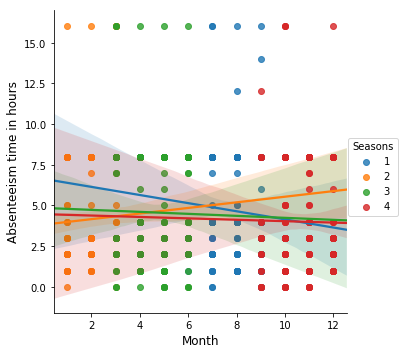

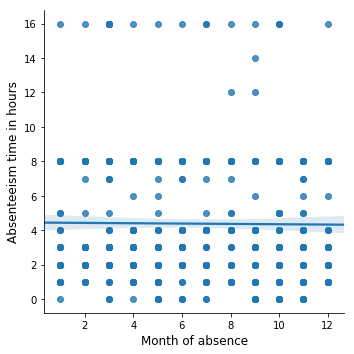

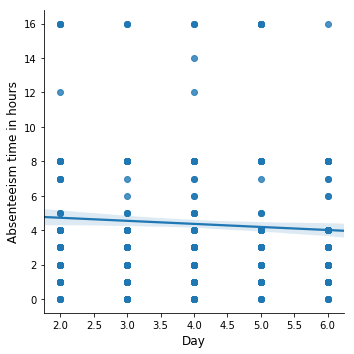

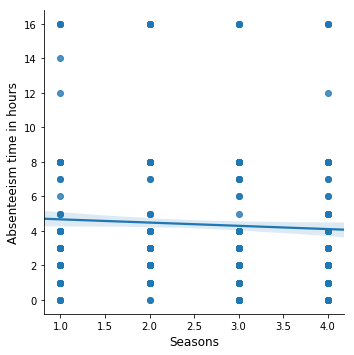

In [32]:
#Checking the trend of absent hours based on months

#line plot for absenteeism hours based on month of absence and categorised by seasons
#For ploting lm plot variables should be numeric not category
#plt.figure(figsize=(20,25))
#plt.suptitle("Distribution of Month, Day, Seasons, based on Absenteeism time in hours", fontsize=20)
#gridspec.GridSpec(4,2)
#plt.subplot2grid((4,2),(0,0))
sns.lmplot(x = 'Month_of_absence', y = 'Absenteeism_time_in_hours', hue = 'Seasons', data = complete_data)
#plt.title("Month-Seasons",fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Absenteeism time in hours', fontsize=12)
plt.savefig('MSAbsenteeismhouts.png')
#plt.show()

#sns.lmplot(x="Month of absence", y="Absenteeism time in hours", col="Seasons", data=complete_data,
#           col_wrap=2, ci=None, palette="muted", size=4,
 #          scatter_kws={"s": 50, "alpha": 1})
    
#Line for month of absence vs absenteeism time
#plt.subplot2grid((4,2),(1,0))
sns.lmplot(x="Month_of_absence", y="Absenteeism_time_in_hours", data = complete_data)
#plt.title("Month of absence ",fontsize=15)
plt.xlabel('Month of absence', fontsize=12)
plt.ylabel('Absenteeism time in hours', fontsize=12)
plt.savefig('Month1.png')
#plt.show()

#line plot for day of week
#plt.subplot2grid((4,2),(2,0))
sns.lmplot(x="Day_of_the_week", y="Absenteeism_time_in_hours", data = complete_data)
#plt.title("Day of week vs Absenteeism time ",fontsize=15)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Absenteeism time in hours', fontsize=12)
plt.savefig('DOW.png')
#plt.show()
#141801518562, ICIC0001418

#line plot for all weeks
#plt.subplot2grid((4,2),(3,1))
sns.lmplot(x="Seasons", y="Absenteeism_time_in_hours", data = complete_data)
#plt.title("Seasons Absenteeism time",fontsize=15)
plt.xlabel('Seasons', fontsize=12)
plt.ylabel('Absenteeism time in hours', fontsize=12)
plt.savefig('Seasons1.png')
#plt.show()

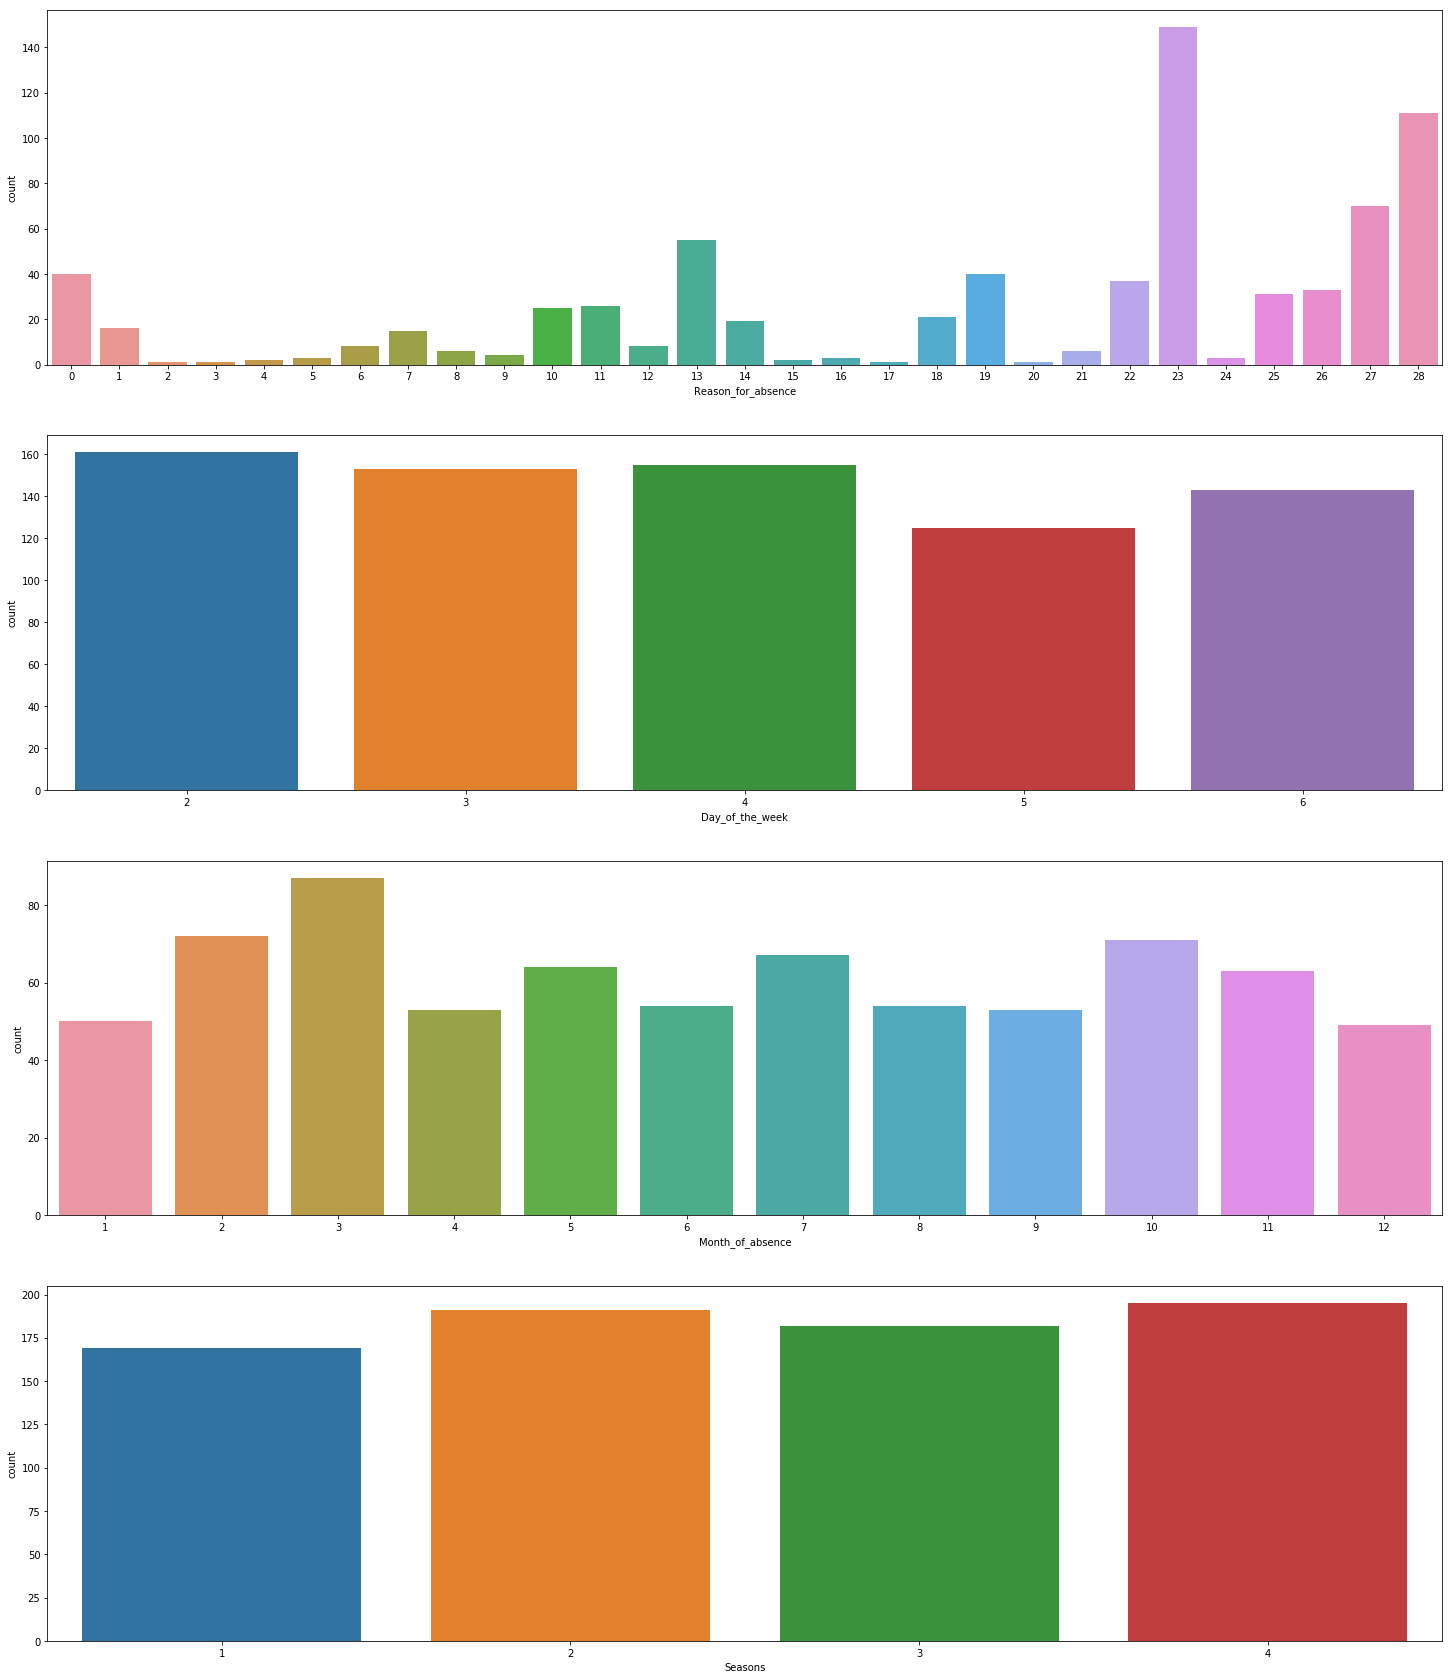

In [33]:
#Searborn - Countplots
#Univariate Analysis: Analysing single variable
#Countplot for reason for absence
plt.figure(figsize=(55,30))
#plt.suptitle("Univariate Analysis: Based of number of Absent days",fontsize=40, )
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.countplot(complete_data['Reason_for_absence'])
plt.savefig('ROA.png')

#Countplot for the distance of employees from residence to work
#plt.subplot2grid((4,2),(0,1))
#sns.countplot(complete_data['Distance_from_Residence_to_Work'])
#plt.savefig('DistancetoWork.png')

#Countplot for no of social smokers and drinkers
plt.subplot2grid((4,2),(1,0))
sns.countplot(complete_data['Day_of_the_week'])
plt.savefig('DOW.png')

#plt.subplot2grid((4,2),(1,1))
#sns.countplot(complete_data['Social_smoker'])
#plt.savefig('Smoker.png')
#sns.set(rc={'figure.figsize':(20,15)})

#Countplot for based on month and season
plt.subplot2grid((4,2),(2,0))
sns.countplot(complete_data['Month_of_absence'])
plt.savefig('Month.png')

plt.subplot2grid((4,2),(3,0))
sns.countplot(complete_data['Seasons'])
plt.savefig('Seasons.png')


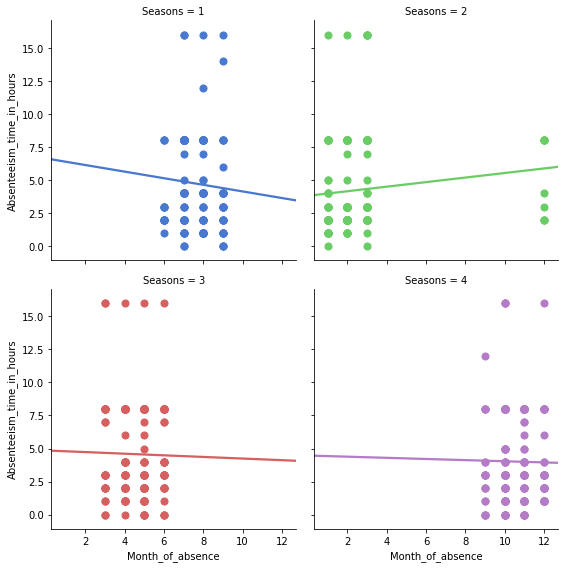

In [34]:
sns.lmplot(x="Month_of_absence", y="Absenteeism_time_in_hours", col="Seasons", hue="Seasons", data=complete_data,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

In [35]:
#Lets check what was the majorty reason for the absent hours
main_col = 'Reason_for_absence'
other_col = ['Disciplinary_failure','Social_drinker', 'Social_smoker']
corr_mat1 = []
for col in other_col[0:]:
    confusion_matrix = pd.crosstab(complete_data[main_col], complete_data[col])
    corr_mat1.append(confusion_matrix)
    
def highlight_min(x):
    is_max = x  == x.max()
    return['background: yellow' if v else '' for v in is_max]

out = pd.concat(corr_mat1, axis = 1, keys = other_col[0:])
out = out.style.apply(highlight_min, axis = 0)
out
#out.to_html('out.html')

#Cross tab is used when the categories for columns which we are comparing are same

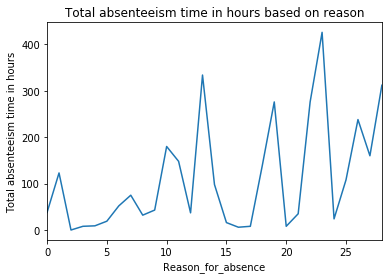

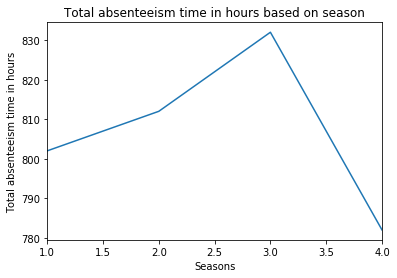

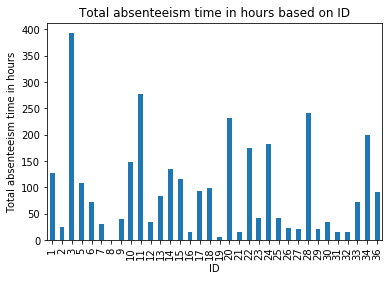

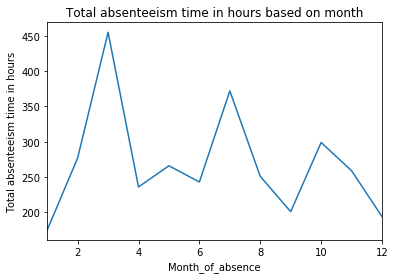

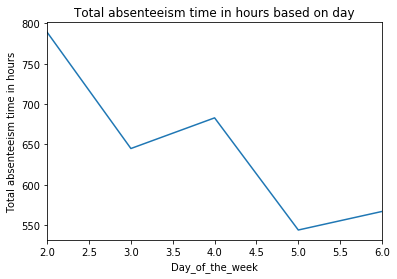

In [36]:
#plt.figure(figsize=(16,22))
#sns.barplot(x ='Reason for absence', y="Absenteeism time in hours", data = complete_data)
#sns.factorplot(x="Reason for absence", y="Absenteeism time in hours", data = var,
 #                  size=6, kind="bar", palette="muted")
var = complete_data.groupby('Reason_for_absence')['Absenteeism_time_in_hours'].sum()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Reason for absence')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on reason") #Chart title
var.plot(kind='line')
plt.savefig('GP_ROA.png')

season_wise = complete_data.groupby('Seasons')['Absenteeism_time_in_hours'].sum()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Seasons')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on season") #Chart title
season_wise.plot(kind='line')
plt.savefig('GP_Seasons.png')

id_wise = complete_data.groupby('ID')['Absenteeism_time_in_hours'].sum().sort_index()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Seasons')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on ID") #Chart title
id_wise.plot(kind='bar')
plt.savefig('GP_ID.png')

#Total absent hours based on months
month_wise = complete_data.groupby('Month_of_absence')['Absenteeism_time_in_hours'].sum()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Month of absence')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on month") #Chart title
month_wise.plot(kind='line')
plt.savefig('GP_Month.png')

#Total absent hours based on days
day_wise = complete_data.groupby('Day_of_the_week')['Absenteeism_time_in_hours'].sum()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Day of the week')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on day") #Chart title
day_wise.plot(kind='line')
plt.savefig('GP_DOW.png')


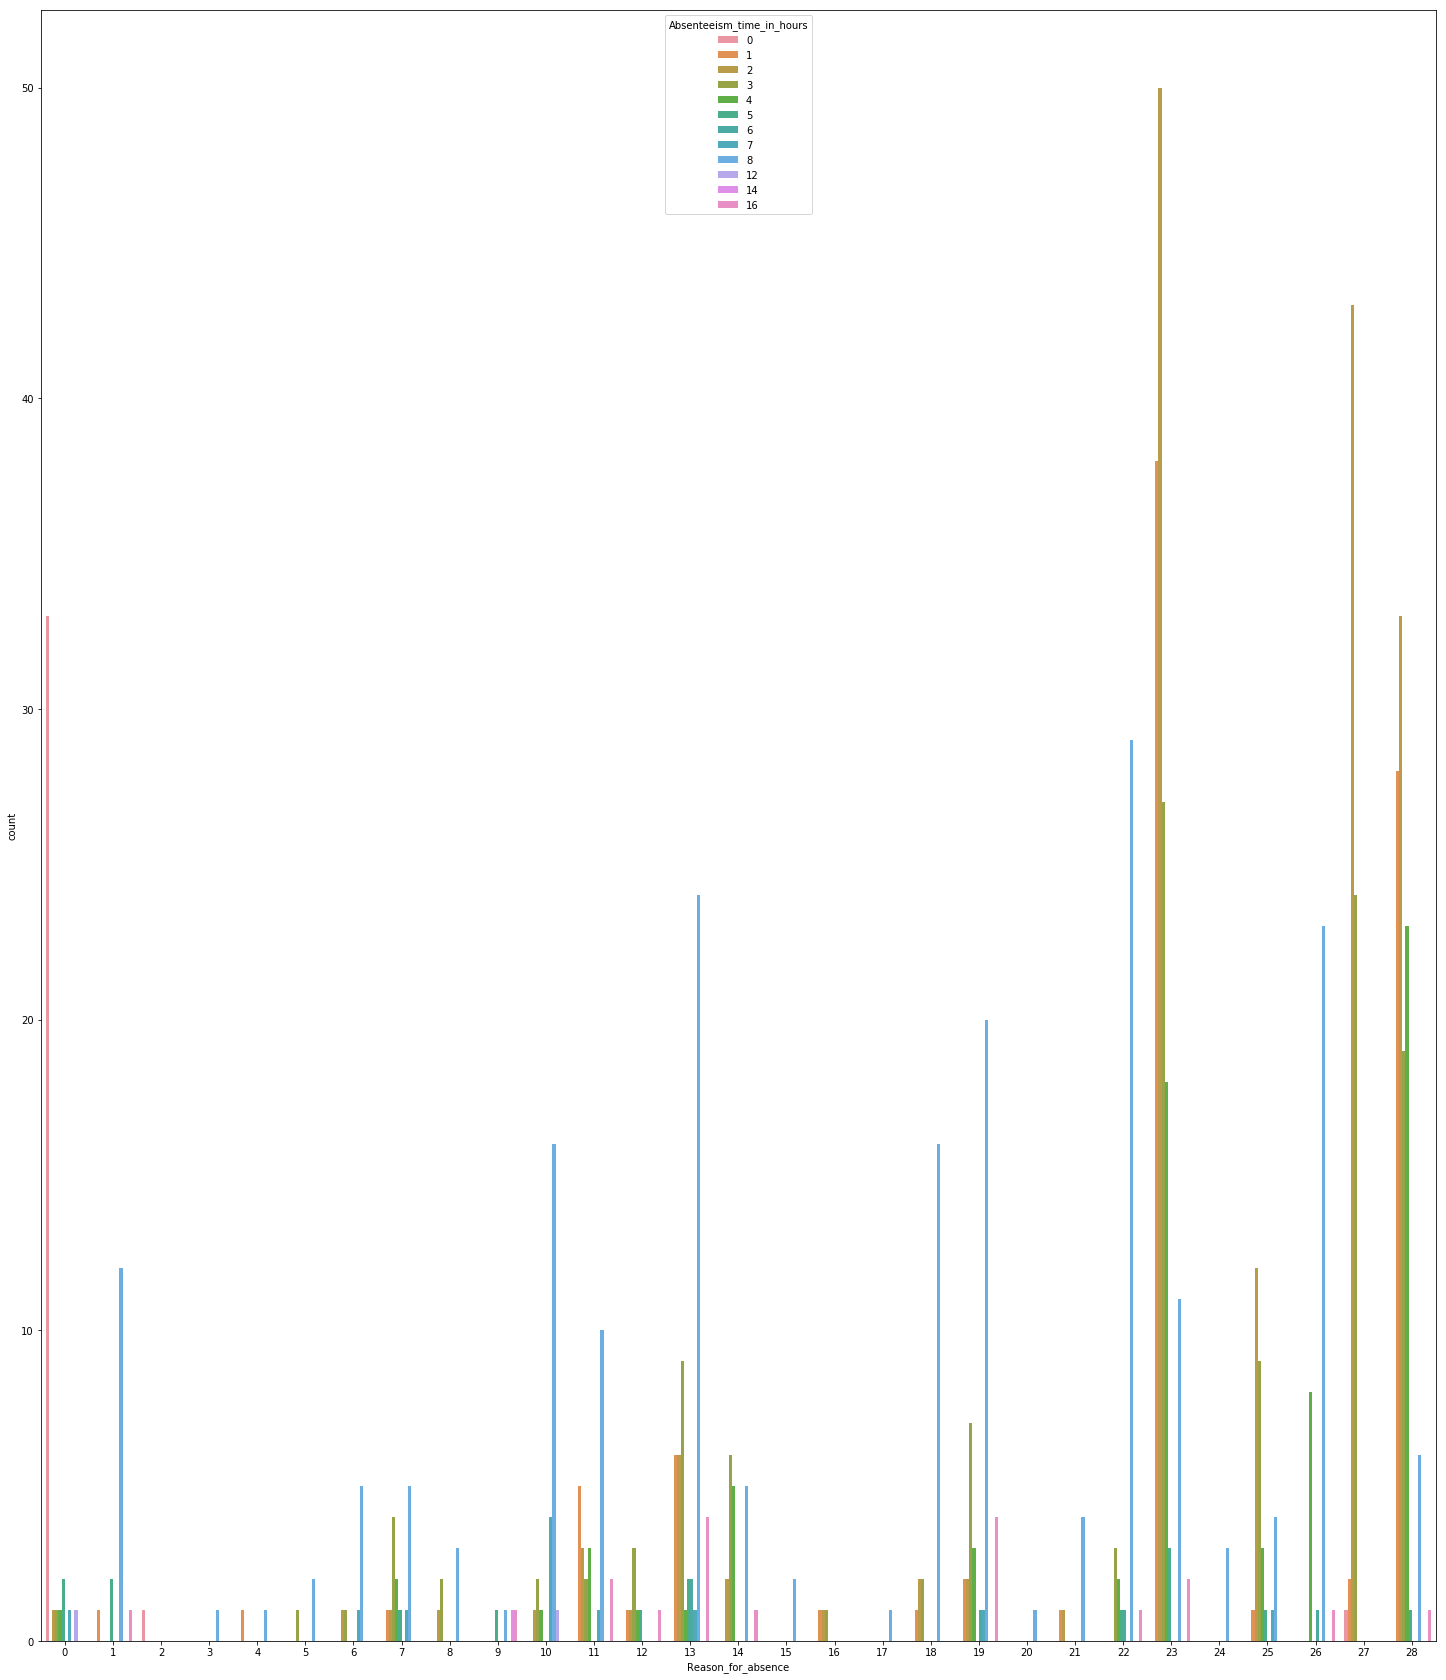

In [37]:
plt.figure(figsize=(25,30))
sns.countplot(x = 'Reason_for_absence', hue = 'Absenteeism_time_in_hours',data = complete_data)

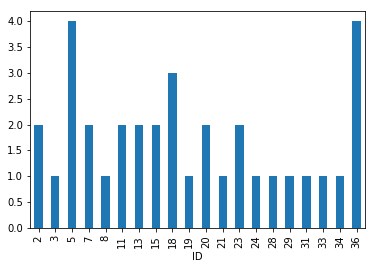

In [38]:
#The below plot shows the no of 0 absence hours entries in the data
complete_data[complete_data['Absenteeism_time_in_hours'] == 0].groupby('ID')['Absenteeism_time_in_hours'].count().sort_index().plot.bar()

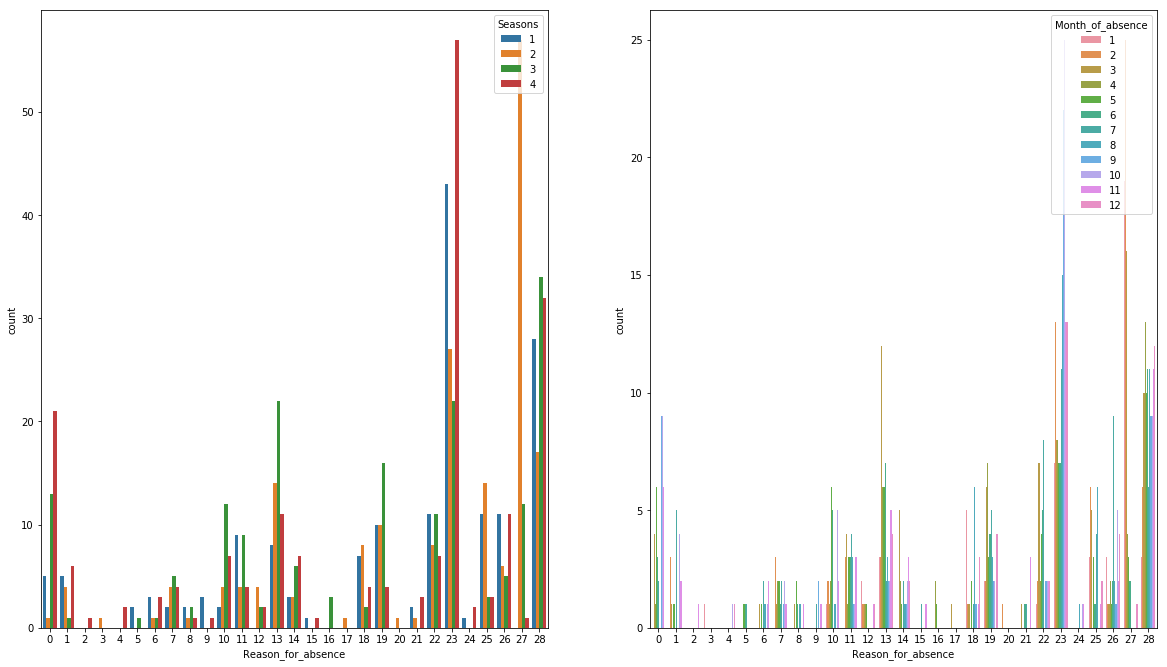

In [39]:
#Analysing multiple categorical variables together
#Checking the count reason for absence based on season

plt.figure(figsize=(20,25))
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.countplot(x = 'Reason_for_absence', hue = 'Seasons', data = complete_data)
#Count of reason for absence based on month
plt.subplot2grid((2,2),(0,1))
sns.countplot(x = 'Reason_for_absence', hue = 'Month_of_absence', data = complete_data)

#sns.set(rc={'figure.figsize':(20,15)})
#sns1.savefig('Season.png')


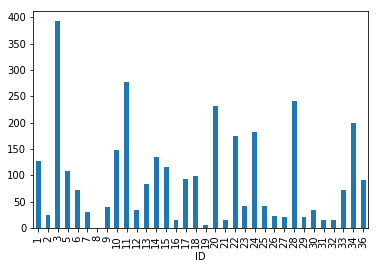

In [40]:
#How is the distribution of the absent hours based on new day?
complete_data['ID'].value_counts().sort_index().plot.bar()
#Employee with ID 3 has absence hours for 112 days. followed by employee with id
#3 employees has 0 absence hours. Id are 4, 8 and 35. There we no reason for absence as well.

#Total hours the employee has been absent
complete_data.groupby('ID')['Absenteeism_time_in_hours'].sum().sort_index().plot.bar()

In [41]:
#There seems to be 7 unique employees and 8 days when the employee has not given any reason for absence.
complete_data[complete_data['Reason_for_absence'] == 0]

,ID,Reason_for_absence,Month_of_absence,Year,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
1,36,0,7,2007,3,1,118,13,18,50,...,1,1,1,1,0,0,98,170,31,0
50,20,0,9,2007,2,4,251,50,11,36,...,0,1,4,1,0,0,65,168,23,12
51,29,0,9,2007,2,4,225,26,9,28,...,1,1,1,0,0,2,69,169,24,0
54,11,0,9,2007,3,4,289,36,13,33,...,1,1,2,1,0,1,90,172,30,0
55,36,0,9,2007,3,4,118,13,18,50,...,1,1,1,1,0,0,98,170,31,2
58,13,0,9,2007,4,4,369,17,12,31,...,1,1,3,1,0,0,70,169,25,0
64,36,0,10,2007,4,4,118,13,18,50,...,1,1,1,1,0,0,98,171,31,5
203,2,0,4,2008,2,3,235,29,12,48,...,1,1,1,0,1,5,88,171,33,0
213,7,0,5,2008,4,3,279,5,14,39,...,1,1,2,1,1,0,68,168,24,0
214,18,0,5,2008,4,3,330,16,4,28,...,1,2,0,0,0,0,84,174,25,0


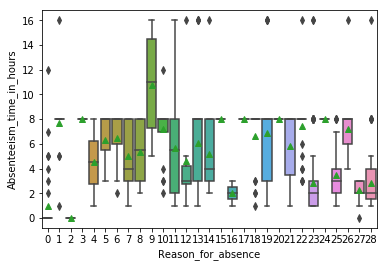

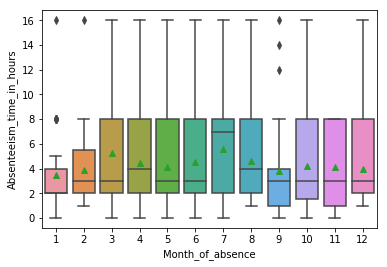

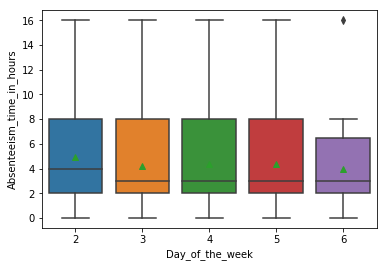

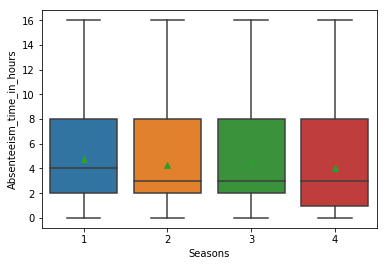

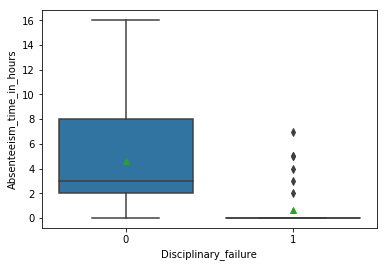

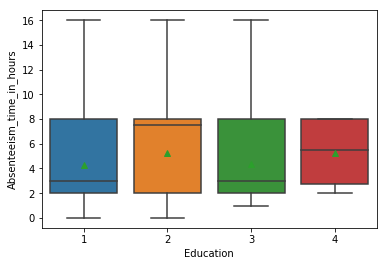

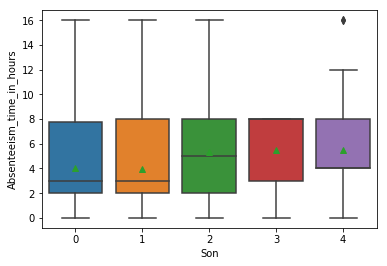

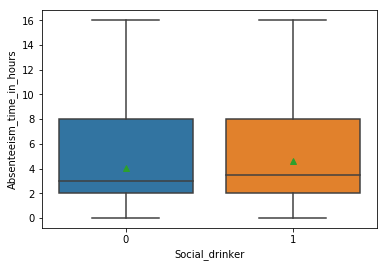

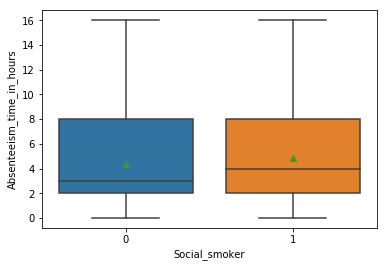

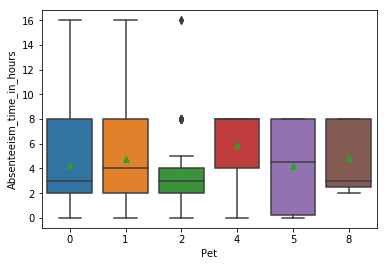

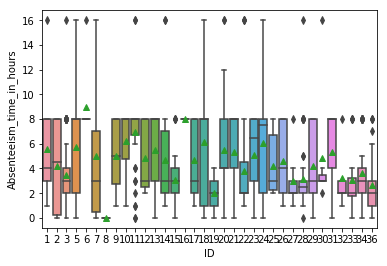

Reason_for_absence      None
Month_of_absence        None
Day_of_the_week         None
Seasons                 None
Disciplinary_failure    None
Education               None
Son                     None
Social_drinker          None
Social_smoker           None
Pet                     None
ID                      None
dtype: object

In [149]:
#Box plot between categorical independent and continuous dependent variables    
def box(col):
    sns.boxplot(x= col, y = complete_data['Absenteeism_time_in_hours'], showmeans=True)
    plt.show()
    
complete_data[category_variables].apply(box)

# Correlation Plot

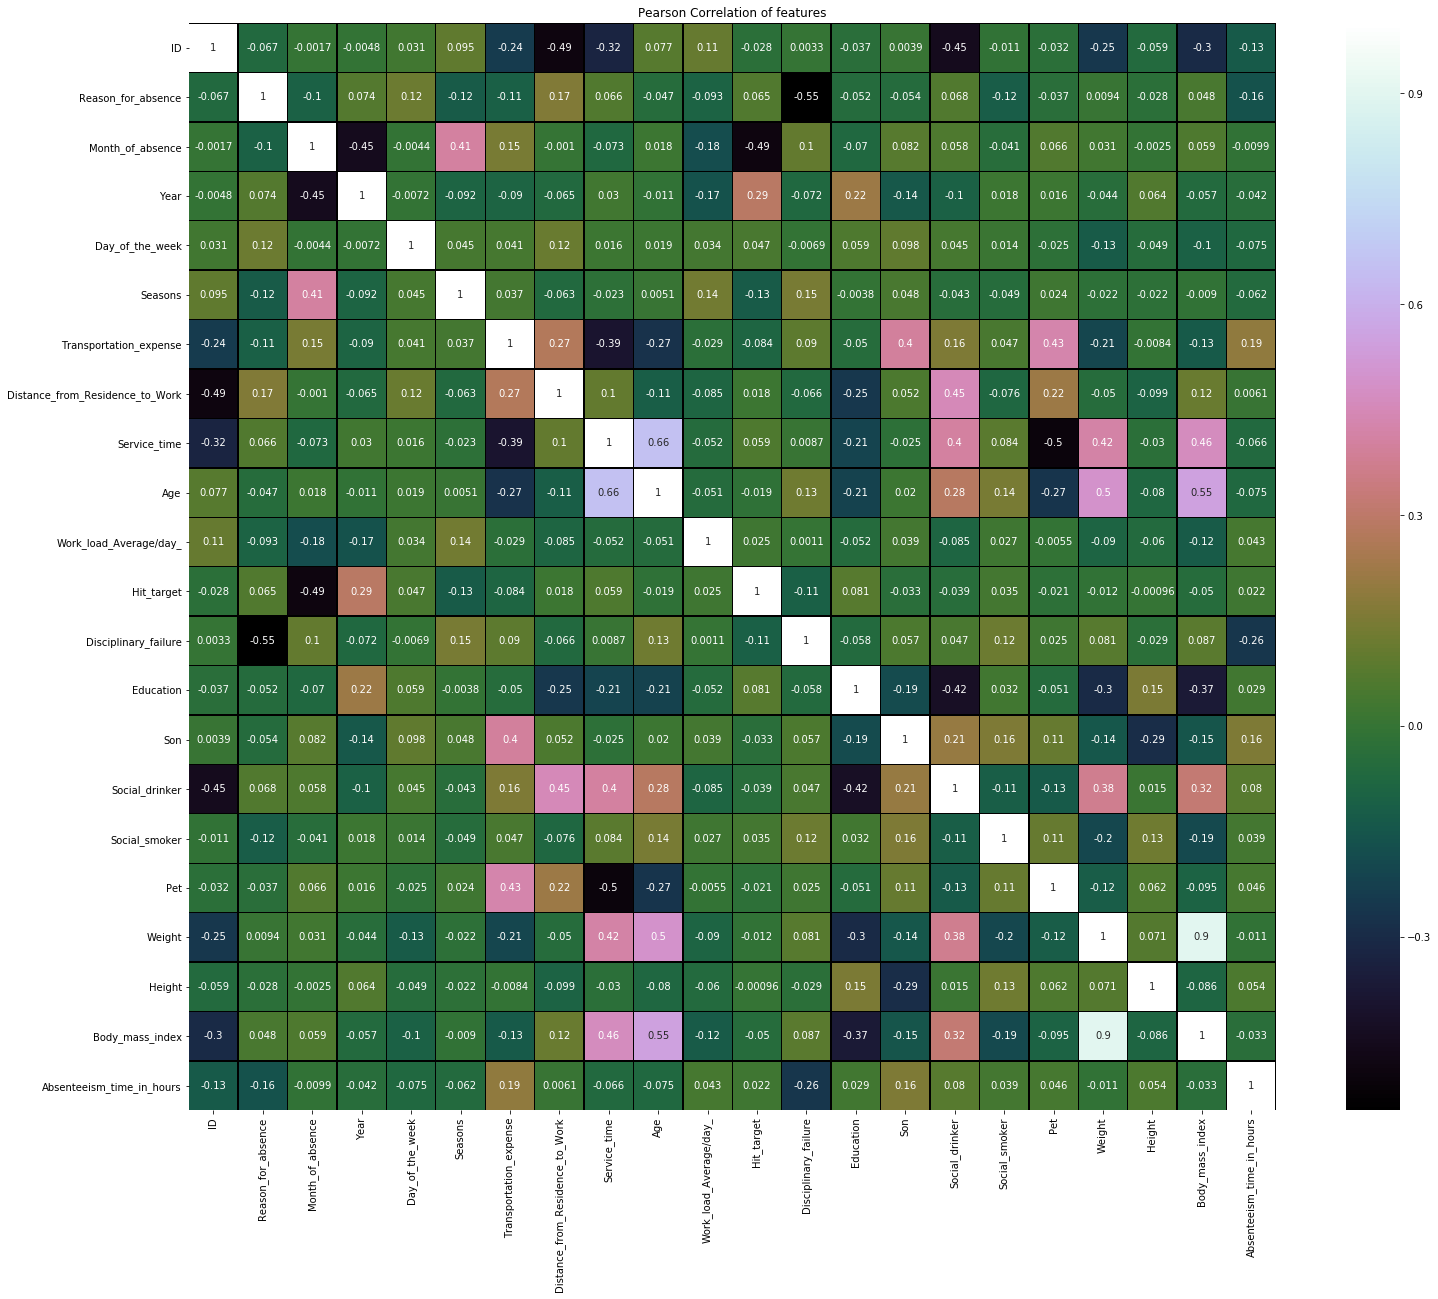

In [44]:
#Correlation Plot
churn_corr = complete_data
#churn_corr = complete_data
#Setting the plot height and width
f, ax = plt.subplots(figsize=(25, 20))

#Generating correlation matrix
corr = churn_corr.corr()

#Ploting using seaborn library
#annot shows the correlation number inside each block
plt.title('Pearson Correlation of features')
correlation_plot = sns.heatmap(corr, linewidths=0.4,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)
plt.savefig("correlation_plot.png")
#BMI formula
#(Weight/(Height)2) *703
#A normal BMI ranges from 18.5 to 24.9
#Overweight is defined as having a BMI of 25 to 29.9.
#A BMI equal or greater than 30 is considered obese.

## Feature importance merging 3 techinques

 **Stability Selection via Randomized Lasso**

In [48]:
# First extract the target variable which is our Absenteeism hours
Y = complete_data.Absenteeism_time_in_hours.values
# Drop Absenteeism_time_in_hours from the complete_data dataframe and create a matrix out of the house data
data_without_target = complete_data.drop(['Absenteeism_time_in_hours'], axis=1)
X = data_without_target.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = data_without_target.columns

In [49]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [51]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

finished


D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


** 2. Recursive Feature Elimination ( RFE )**

In [52]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


**3. Linear Model Feature Ranking**

In [53]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

In [54]:
np.abs(lr.coef_)

array([  5.02887752e-02,   1.72065978e-01,   4.29796544e-02,
         1.21838380e-01,   6.49135175e-02,   5.99930134e-02,
         3.74472970e-03,   2.44915245e-02,   1.24510774e-01,
         3.77010338e-03,   1.67895582e-06,   6.89387784e-03,
         7.85633753e+00,   8.62201084e-02,   4.33707000e-01,
         8.40243358e-01,   5.93359028e-01,   1.23323756e-01,
         3.33948700e-02,   1.18968304e-01,   1.46851631e-01])

**4. Random Forest feature ranking**

In [55]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50building tree 5 of 50

building tree 6 of 50
building tree 7 of 50
building tree 8 of 50building tree 9 of 50

building tree 11 of 50building tree 10 of 50

building tree 12 of 50building tree 13 of 50

building tree 14 of 50building tree 15 of 50

building tree 16 of 50building tree 17 of 50

building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50building tree 23 of 50

building tree 24 of 50building tree 26 of 50building tree 25 of 50


building tree 27 of 50
building tree 28 of 50building tree 29 of 50

building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50building tree 38 of 50
building tree 39 of 50

building tree 40 of 50building tree 41 of 50

building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50building tree 46 of 50building tree 47 of 50


building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


# 6. Creating the Feature Ranking Matrix

In [56]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
ID	0.01	0.01	0.19	0.35	0.01	0.0	0.1
Reason_for_absence	0.02	0.02	1.0	0.75	0.02	0.0	0.3
Month_of_absence	0.0	0.01	0.22	0.3	0.01	0.0	0.09
Year	0.01	0.02	0.1	0.45	0.02	0.0	0.1
Day_of_the_week	0.01	0.01	0.25	0.65	0.01	0.0	0.16
Seasons	0.01	0.01	0.1	0.7	0.02	0.0	0.14
Transportation_expense	0.0	0.0	0.19	0.05	0.0	0.0	0.04
Distance_from_Residence_to_Work	0.0	0.0	0.09	0.2	0.0	0.0	0.05
Service_time	0.01	0.02	0.06	0.55	0.02	0.0	0.11
Age	0.0	0.0	0.08	0.15	0.0	0.0	0.04
Work_load_Average/day_	0.0	0.0	0.36	0.0	0.0	0.0	0.06
Hit_target	0.0	0.0	0.23	0.1	0.0	0.0	0.06
Disciplinary_failure	1.0	1.0	0.49	1.0	1.0	0.0	0.75
Education	0.0	0.01	0.03	0.8	0.01	0.0	0.14
Son	0.06	0.06	0.06	0.85	0.07	0.0	0.18
Social_drinker	0.03	0.11	0.01	0.9	0.11	0.0	0.19
Social_smoker	0.0	0.08	0.0	0.95	0.06	0.0	0.18
Pet	0.01	0.02	0.01	0.4	0.02	0.0	0.08
Weight	0.0	0.0	0.08	0.25	0.0	0.0	0.06
Height	0.01	0.02	0.13	0.6	0.02	0.0	0.13
Body_mass_index	0.0	0.02	0.12	0.5	0.02	0.0	0.11


In [57]:
ranks.keys()

dict_keys(['rlasso/Stability', 'RFE', 'LinReg', 'Ridge', 'Lasso', 'RF', 'Mean'])

In [58]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

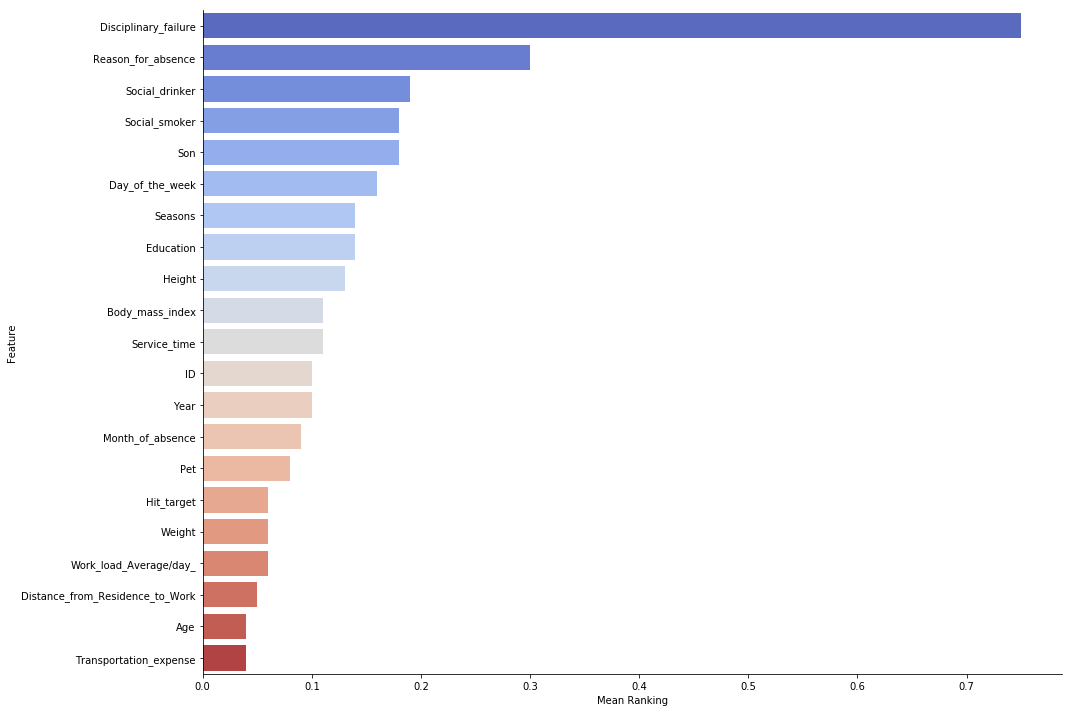

In [59]:
# Let's plot the ranking of the features
plt.figure(figsize=(25,30))
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=10, aspect=1.5, palette='coolwarm')
plt.savefig('feature_importance.png')

## Simple Linear Regression 

In [60]:
#Grouping the data based on year of month and total absenteeism hour
ts = pd.DataFrame(complete_data.groupby(['Year' , 'Month_of_absence'])['Absenteeism_time_in_hours'].sum())

In [61]:
#As linear regression doesn't take date as input converting months into sequence of number starting from 1 to 37( as we have 37 months)
linear_data = pd.DataFrame( {'Month' : range(1,38,1), 'Absenteeism_time_in_hours': ts.Absenteeism_time_in_hours})
linear_data.reset_index(drop = True, inplace = True)
cols_name = linear_data.columns.tolist()
column_to_move = "Month"
new_position = 0
cols_name.insert(new_position, cols_name.pop(cols_name.index(column_to_move)))
linear_data = linear_data[cols_name]

In [62]:
linear_data

,Month,Absenteeism_time_in_hours
0,1,88
1,2,109
2,3,70
3,4,79
4,5,82
5,6,61
6,7,65
7,8,87
8,9,195
9,10,83


In [63]:
#Saving the month data into month variable making it as column vector by inserting an axis along second dimension
Month = linear_data['Month'][:, np.newaxis]
#Saving the absenteeism time in another variable
Absenteeism_time_in_hours  = linear_data['Absenteeism_time_in_hours']

In [64]:
#Splitting into train and test, with 80:20 ratio
x_train, x_cv, y_train, y_cv = train_test_split(Month, Absenteeism_time_in_hours, test_size = 0.2)

In [65]:
#Making  linear regression object
lr = LinearRegression()
#Training the model
fit = lr.fit(x_train, y_train)

b_0   = fit.intercept_
coeff = fit.coef_
print('Intercept:  %.4f' % b_0)
print('Month Coefficient value: ' % coeff)

Intercept:  92.2478
Month Coefficient value: 


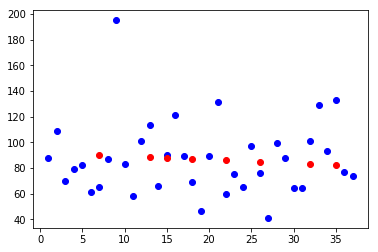

In [66]:
#Making predictions
pred = lr.predict(x_cv)

#Plotting the prediction with the original values plot
plt.scatter(Month, Absenteeism_time_in_hours, color='b')
plt.scatter(x_cv, pred, color='red')
plt.show()

In [67]:
#Making the predicted month column vector from 38-55 as we need to predict for till 54(which means December 2011)
predict_month = np.array(
  [a for a in range(38, 55)]
)[:, np.newaxis]

#Forecating the absenteese hour per month
forecast_2011 = lr.predict(predict_month)
forecast_2011

array([ 81.29624998,  81.00805112,  80.71985227,  80.43165341,
        80.14345456,  79.8552557 ,  79.56705685,  79.27885799,
        78.99065914,  78.70246028,  78.41426143,  78.12606257,
        77.83786372,  77.54966486,  77.26146601,  76.97326715,  76.6850683 ])

** Linear Regression Model Performance Measures**

In [68]:
# Adjusted R-square
score = lr.score(Month[:], Absenteeism_time_in_hours[:])
print ('Linear Regression without trend R square: %.4f' % score)

Linear Regression without trend R square: -0.0091


In [69]:
lin_mse = mean_squared_error(pred, y_cv)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression without trend RMSE: %.4f' % lin_rmse)

Linear Regression without trend RMSE: 25.5509


In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_cv, pred)

24.962022545988123

In [71]:
regr = OLS(Absenteeism_time_in_hours, add_constant(Month)).fit()
print("Akaike information criterion: %.4f " %regr.aic)

Akaike information criterion: 357.1260 


## Linear Regression with trend

In [72]:
#Lets calculate the trend first and forecast the trend for 2011 year
linear_data.head()

,Month,Absenteeism_time_in_hours
0,1,88
1,2,109
2,3,70
3,4,79
4,5,82


In [ ]:
from matplotlib import pyplot

We will take out the trend part: A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.
How are we going to forecast with trend?
    *First we will take out the trend part from the series by taking the difference between the original observation and the observation at the previous time step.
    *Then we will forcast the trend values till December 2011 using the following trend.
    *Then we will forecast the absenteese hours per month using the month and forecasted trend as predictor variable.

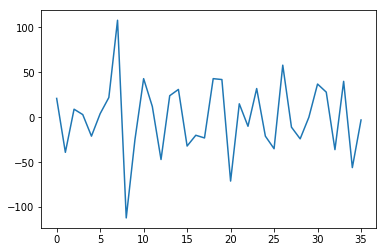

In [73]:
#Taking the trend part out of the series by taking the difference between the original observation and the observation at the
#previous step
X = linear_data.Absenteeism_time_in_hours
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

Because no difference value can be created for the first observation (there is nothing for it to be subtracted from), the new dataset contains one less record.
We will add a average of difference to the first variable to balance our dataset

In [74]:
#As in diff variable the first observation will be NA to calculate the trend as we need two variables to calculate trend, I'm adding a mean of trend as the first observation
#value for trend so that we can use it in linear regression
aver = np.mean(diff)

#Adding this aver value at start
diff.insert(1, aver) 

#Length of trend
len(diff)

37

In [75]:
#Lets make a data frame with trend and month and then forecast the trend
linear_data_trend = pd.DataFrame( {'Month' : range(1,38,1), 'Trend': diff})

#Converting the month to column vector 2D array
Month = linear_data_trend['Month'][:, np.newaxis]
Trend  = linear_data_trend['Trend']

In [76]:
#Making the linear regression model
lr = LinearRegression()
#Fitting the model
fit = lr.fit(Month, Trend)

b_0   = fit.intercept_
coeff = fit.coef_

In [77]:
#Making the predicted month column vector array from 38-55 as we need to predict trend till 54(which means December 2011)
predict_month_trend = np.array(
  [a for a in range(38, 55)]
)[:, np.newaxis]

#Forecasting the trend till December 2011
forecast_trend = lr.predict(predict_month_trend)
forecast_trend

array([-1.52577578, -1.58561193, -1.64544808, -1.70528423, -1.76512038,
       -1.82495654, -1.88479269, -1.94462884, -2.00446499, -2.06430114,
       -2.1241373 , -2.18397345, -2.2438096 , -2.30364575, -2.3634819 ,
       -2.42331805, -2.48315421])

In [78]:
#Lets make a new Data frame with Month, trend and Absenteese hours
linear_TA = pd.DataFrame({'Month' : range(1,38,1), 'Trend': diff , 'Absenteeism_time_in_hours': linear_data.Absenteeism_time_in_hours})

In [128]:
#Saving the predictor variables into a new variable 
X = linear_TA.loc[:,['Month','Trend']]
#Splitting into train and test. 80:20
x_train, x_cv, y_train, y_cv = train_test_split(X, linear_TA.Absenteeism_time_in_hours, test_size = 0.2)

In [129]:
#Training the model
fit_tren = lr.fit(x_train, y_train)

#Predicting the absentese hours for the test feature i.e Month and trend 
pred = lr.predict(x_cv)

In [130]:
print("Estimated intercept coefficient", lr.intercept_)
print('Number of coefficients', len(lr.coef_))
print("Coefficients Values" , lr.coef_)

Estimated intercept coefficient 86.0588288525
Number of coefficients 2
Coefficients Values [ 0.13118818  0.50721732]


In [131]:
#Making the dataframe with forecasted trend and the month 
predict_trend = pd.DataFrame({'Month': range(38,55,1), 'Trend' : forecast_trend})

#Forecast with trend
forecast_2011 = lr.predict(predict_trend)
forecast_2011

array([ 90.27007985,  90.37091809,  90.47175634,  90.57259459,
        90.67343284,  90.77427109,  90.87510934,  90.97594759,
        91.07678584,  91.17762408,  91.27846233,  91.37930058,
        91.48013883,  91.58097708,  91.68181533,  91.78265358,  91.88349182])

**Model Performance Evaluation**

In [132]:
#Getting the R square score
score = lr.score(x_train, y_train)
print ('Linear Regression without trend R square: %.4f' % score)

Linear Regression without trend R square: 0.5078


In [133]:
#Calculating the Root mean square error
lin_mse = mean_squared_error(pred, y_cv)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 18.5194


In [134]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_cv, pred)

19.289117217330691

In [135]:
#AIC Score
regr = OLS(y_train, add_constant(x_train)).fit()
print('Akaike information criterion: %.4f' % regr.aic)

Akaike information criterion: 265.6515


## Time Series Analysis

In [136]:
ts = complete_data.groupby(['Year' , 'Month_of_absence'])['Absenteeism_time_in_hours'].sum()

In [137]:
ts.index=pd.date_range(start = '2007-07-01',end='2010-08-01', freq = 'M')

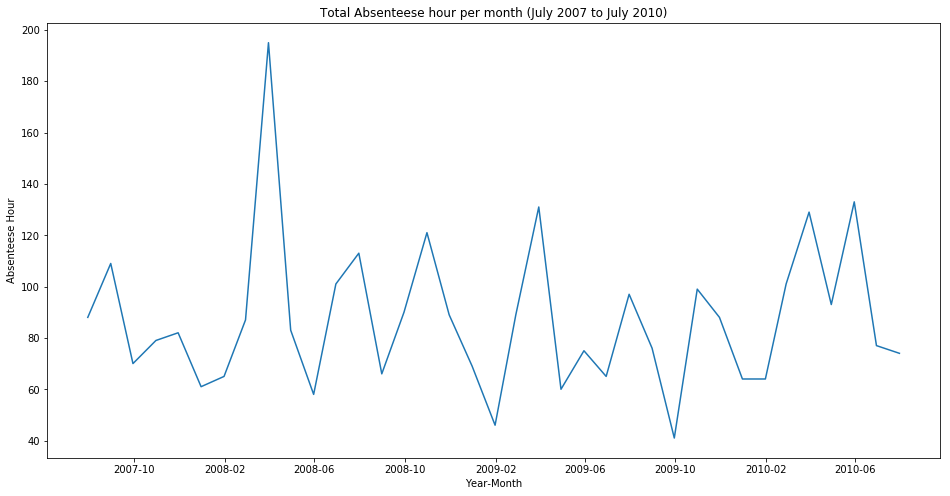

In [138]:
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Absenteese hour per month (July 2007 to July 2010)')
plt.xlabel('Year-Month')
plt.ylabel('Absenteese Hour')
plt.plot(ts)
plt.savefig('TotalAbsenteesehr_permonth.png')

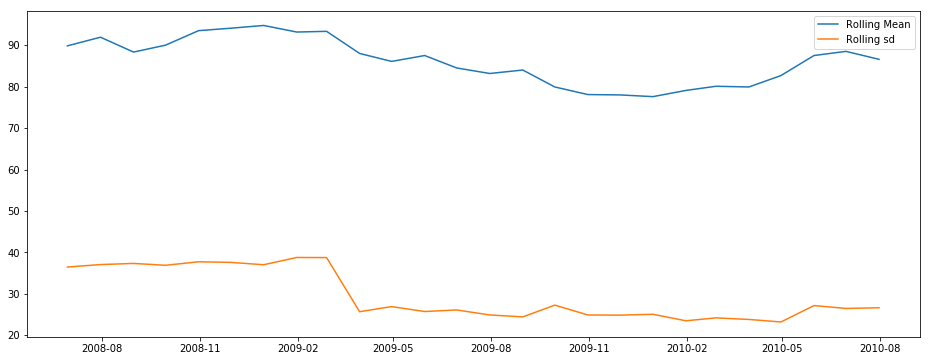

In [139]:
#Rolling mean and sd for year
plt.figure(figsize=(16,6))
#As we have a small time series we are checking the rolling mean and sd. 
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean')
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd')
plt.legend()
plt.savefig('Rolling_means_sd.png')

**Quick observations:**
By Looking at the Total Absenteese per month plot we can say that there is not much seasonality and no trend in the time series.
The rolling mean plot shows that the mean of the series is not a function of time, it remains constant over time.

Let's check that with a quick decomposition into Trend, seasonality and residuals.

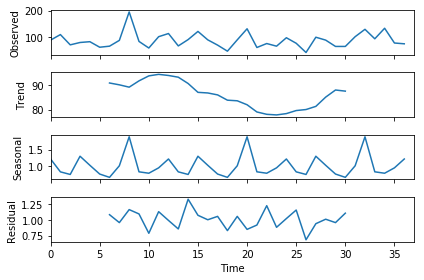

In [140]:
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
plt.savefig("Decomposition.png")
#fig.show()

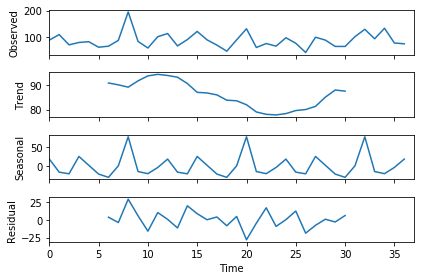

In [141]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
plt.savefig('Decomposition_add.png')
#fig.show()

## Stationarity:

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time
Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


We will implement ADF( Augmented Dicky Fuller Test), one of the statistical test to check the staionarity in the data.


# Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [142]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -5.702235e+00
p-value                        7.629028e-07
#Lags Used                     1.000000e+00
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64


**As our p-value is lower than 0.05 which means we can reject the null hypothesis and accept the alternate hypothesis, which says tht
the data is stationary.**
**As our time series already seems to be stationary, there is no need to perform actions to make it stationary**

## Forecasting a Time Series

**Using ARIMA**

## ACF AND PACF

In [ ]:
#PACF plot tells about p; autoregression part
#ACF plot tells about q: Moving average part

D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


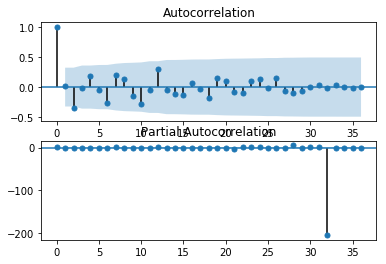

In [143]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca())
pyplot.show()

## Seasonal ARIMA

In [144]:
train = pd.DataFrame(ts[0:30])
test = pd.DataFrame(ts[30:37])

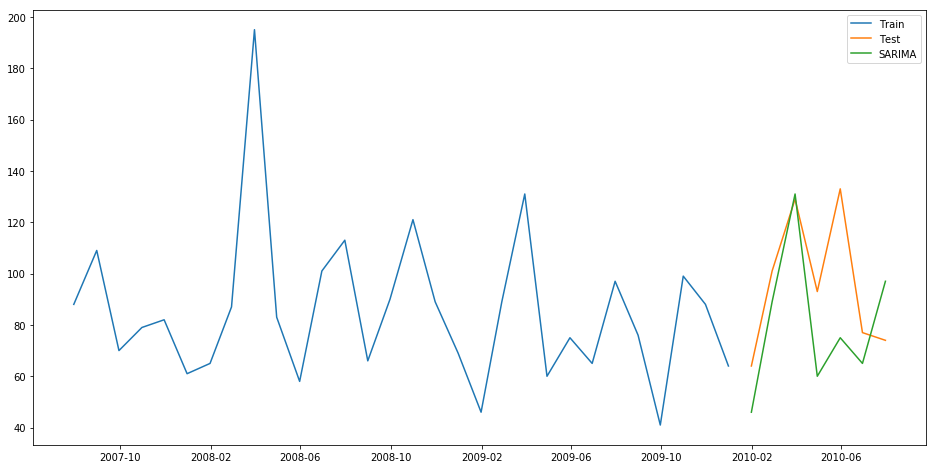

In [145]:
y_hat_avg = test.copy()
#we are using the same order as used in ARIMA in R with seasonal difference
#(p,d,q) are non seasonal paramters
#(P,D,Q,freq) are seasonal parameters, as we have used 1 seasonal differencing and 12 as we have monthly data
history = [x for x in train]
fit1 = sm.tsa.statespace.SARIMAX(train.Absenteeism_time_in_hours, order=(0, 0, 0),seasonal_order=(0,1,0,12)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2010-01-31", end= "2011-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Absenteeism_time_in_hours'], label='Train')
plt.plot(test['Absenteeism_time_in_hours'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

**Model Performance**

In [146]:
#Root mean square error
rms = np.sqrt(mean_squared_error(test.Absenteeism_time_in_hours, y_hat_avg.SARIMA))
print("Root mean square error for SARIMA: %.4f" % rms)

Root mean square error for SARIMA: 28.2792


In [147]:
#Mean Percentage Absolute error
mape = mean_absolute_percentage_error(test.Absenteeism_time_in_hours, y_hat_avg.SARIMA)
print("Mean Absolute Percentage error for SARIMA: %.4f" % rms)

Mean Absolute Percentage error for SARIMA: 28.2792


In [148]:
y_hat_avg['SARIMA'] = fit1.predict(start="2010-1-31", end="2011-12-31")
y_hat_avg['SARIMA']

2010-01-31     46.0
2010-02-28     89.0
2010-03-31    131.0
2010-04-30     60.0
2010-05-31     75.0
2010-06-30     65.0
2010-07-31     97.0
Freq: M, Name: SARIMA, dtype: float64